In [113]:
import os, random, pickle, json
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [111]:
ims_path1 = '../data/real/WWMR-DB - Part 1'
ims_path2 = '../data/real/WWMR-DB - Part 2'
labs_path = '../data/real/WWMR-DB - Labels/Labels/YOLO'
tensor_path = '../data/real'

In [76]:
def get_image_sizes(ims_path):
    '''Get a dictionary of image sizes mapped to list of image paths'''
    im_sizes = {}
    mask_stats = set(['MRCW', 'MRFH', 'MRHN', 'MRNC', 'MRNN', 'MRNW', 'MRTN', 'MSFC'])
    mask_types = set(['DRNV', 'DRWV', 'NMDM', 'SRGM'])
    head_angles = set(['0000', '0045', '0090'])
    
    i=0
    # image name encodes the following (if present): subjnum_maskstat_masktype_headangle_maskinbackgroundforeground.jpg
    for path, _, fns in os.walk(ims_path):
        for fn in fns:
            if fn.lower().endswith('.jpg'):
                im_name = fn[:-4]
            elif fn.lower().endswith('.jpeg'):
                im_name = fn[:-5]
            else:
                continue
            
            items = im_name.split('_')
            
            if len(items)<3 or len(items)>5:
                print(items)
                return {}
            
            subj = items[0]
            items = items[1:]
            mask_stat = ''
            head_angle = ''
            mask_type = 'NONE'
            back_fore = 'NA'
            
            for item in items:
                if item in mask_stats:
                    mask_stat = item
                elif item in mask_types:
                    mask_type = item
                elif item in head_angles:
                    head_angle = item
                elif item=='B' or item=='F':
                    back_fore = item
                    
            if not mask_stat or not head_angle:
                print('missing mask stat or head angle', im_name)
                continue
            
            fp = '%s/%s' % (path, fn)
            
            #read the image with opencv2
            try:
                im = cv2.imread(fp)
            except Exception as ex:
                print('couldnt open %s: %s' % (fp, str(ex)))
                continue
                
            if im is None:
                print('couldnt open %s' % (fp))
                continue
                
            #get and store the image size
            sz = im.shape
            
            im_sizes[im_name] = {'path':fp, 
                                      'size':sz,
                                      'subject':subj, 
                                      'mask_status':mask_stat, 
                                      'mask_type':mask_type, 
                                      'head_angle':head_angle, 
                                      'mask_background_foreground':back_fore}
            
            i+=1
            if i%100==0:
                print('\n', i, im_sizes[im_name])
                
    print('%s files processed' % i)
    
    return im_sizes

In [77]:
im_sizes = get_image_sizes(ims_path1)


 100 {'path': '../data/real/WWMR-DB - Part 1\\Subject 10\\Mask Or Respirator Hanging From An Ear\\Surgical Mask/0010_MRHN_SRGM_0090_F.jpg', 'size': (4608, 3456, 3), 'subject': '0010', 'mask_status': 'MRHN', 'mask_type': 'SRGM', 'head_angle': '0090', 'mask_background_foreground': 'F'}

 200 {'path': '../data/real/WWMR-DB - Part 1\\Subject 15\\Mask Or Respirator Correctly Worn\\Surgical Mask/0015_MRCW_SRGM_0090.jpg', 'size': (6528, 4896, 3), 'subject': '0015', 'mask_status': 'MRCW', 'mask_type': 'SRGM', 'head_angle': '0090', 'mask_background_foreground': 'NA'}

 300 {'path': '../data/real/WWMR-DB - Part 1\\Subject 2\\Mask Or Respirator On The Tip Of The Nose\\Surgical Mask/0002_MRTN_SRGM_0000.jpg', 'size': (4032, 1860, 3), 'subject': '0002', 'mask_status': 'MRTN', 'mask_type': 'SRGM', 'head_angle': '0000', 'mask_background_foreground': 'NA'}

 400 {'path': '../data/real/WWMR-DB - Part 1\\Subject 4\\Mask Or Respirator On The Tip Of The Nose\\Non-Medical Mask/0004_MRTN_NMDM_0000.jpg', 'si

In [78]:
im_sizes.update(get_image_sizes(ims_path2))


 100 {'path': '../data/real/WWMR-DB - Part 2\\Subject 19\\Mask Or Respirator On The Tip Of The Nose\\Surgical Mask/0019_MRTN_SRGM_0000.jpg', 'size': (3264, 2448, 3), 'subject': '0019', 'mask_status': 'MRTN', 'mask_type': 'SRGM', 'head_angle': '0000', 'mask_background_foreground': 'NA'}

 200 {'path': '../data/real/WWMR-DB - Part 2\\Subject 25\\Mask Or Respirator Hanging From An Ear\\Surgical Mask/0025_MRHN_SRGM_0000.jpg', 'size': (4624, 3472, 3), 'subject': '0025', 'mask_status': 'MRHN', 'mask_type': 'SRGM', 'head_angle': '0000', 'mask_background_foreground': 'NA'}

 300 {'path': '../data/real/WWMR-DB - Part 2\\Subject 30\\Mask Or Respirator Hanging From An Ear\\Disposable Respirator Without Valve/0030_MRHN_DRNV_0000.JPG', 'size': (3456, 5184, 3), 'subject': '0030', 'mask_status': 'MRHN', 'mask_type': 'DRNV', 'head_angle': '0000', 'mask_background_foreground': 'NA'}

 400 {'path': '../data/real/WWMR-DB - Part 2\\Subject 33\\Mask Or Respirator On The Tip Of The Nose\\Surgical Mask/0033

In [114]:
with open('%s/im_data.json' % tensor_path, 'w') as o:
    json.dump(im_sizes, o)

In [79]:
y_subj = set()
y_mask_stat = set()
y_mask_type = set()
y_angle = set()

for d in im_sizes.values():
    y_subj.add(d['subject'])
    y_mask_stat.add(d['mask_status'])
    y_mask_type.add(d['mask_type'])
    y_angle.add('%s_%s' % (d['head_angle'], d['mask_background_foreground']))
    
lab2idx_subj = {l:i for i,l in enumerate(sorted(y_subj))}
lab2idx_mask_stat = {l:i for i,l in enumerate(sorted(y_mask_stat))}
lab2idx_mask_type = {l:i for i,l in enumerate(sorted(y_mask_type))}
lab2idx_angle = {l:i for i,l in enumerate(sorted(y_angle))}

lab2idx_subj, lab2idx_mask_stat, lab2idx_mask_type, lab2idx_angle

({'0001': 0,
  '0002': 1,
  '0003': 2,
  '0004': 3,
  '0005': 4,
  '0006': 5,
  '0007': 6,
  '0008': 7,
  '0009': 8,
  '0010': 9,
  '0011': 10,
  '0012': 11,
  '0013': 12,
  '0014': 13,
  '0015': 14,
  '0016': 15,
  '0017': 16,
  '0018': 17,
  '0019': 18,
  '0020': 19,
  '0021': 20,
  '0022': 21,
  '0023': 22,
  '0024': 23,
  '0025': 24,
  '0026': 25,
  '0027': 26,
  '0028': 27,
  '0029': 28,
  '0030': 29,
  '0031': 30,
  '0032': 31,
  '0033': 32,
  '0034': 33,
  '0035': 34,
  '0036': 35,
  '0037': 36,
  '0038': 37,
  '0039': 38,
  '0040': 39,
  '0041': 40,
  '0042': 41},
 {'MRCW': 0,
  'MRFH': 1,
  'MRHN': 2,
  'MRNC': 3,
  'MRNN': 4,
  'MRNW': 5,
  'MRTN': 6,
  'MSFC': 7},
 {'DRNV': 0, 'DRWV': 1, 'NMDM': 2, 'NONE': 3, 'SRGM': 4},
 {'0000_NA': 0,
  '0045_B': 1,
  '0045_F': 2,
  '0045_NA': 3,
  '0090_B': 4,
  '0090_F': 5,
  '0090_NA': 6})

In [ ]:
with open('%s/lab2idx_subj.pkl' % tensor_path, 'wb') as o:
    pickle.dump(lab2idx_subj, o)
with open('%s/lab2idx_mask_stat.pkl' % tensor_path, 'wb') as o:
    pickle.dump(lab2idx_mask_stat, o)
with open('%s/lab2idx_mask_type.pkl' % tensor_path, 'wb') as o:
    pickle.dump(lab2idx_mask_type, o)
with open('%s/lab2idx_angle.pkl' % tensor_path, 'wb') as o:
    pickle.dump(lab2idx_angle, o)

In [ ]:
#Each image has two label files: These files contain the bounding boxes of the face of the person,
# the mask or the respirator, and both
# Example YOLO file
#2 0.547938 0.643229 0.356701 0.289159
#6 0.534149 0.525077 0.432732 0.525849
#0 0.533247 0.514564 0.429897 0.505208

In [80]:
def get_bounding_boxes(im_sizes, labs_path):
    i=0
    for path, _, fns in os.walk(labs_path):
        for fn in fns:
            if not fn.endswith('.txt'):
                continue
            if fn.startswith('classes'):
                continue
                
            im_name = fn[:-4]
            
            if not im_name in im_sizes:
                print('%s not in im sizes' % im_name)
                continue
            
            fp = '%s/%s' % (path, fn)
            
            x, y, w, h = 0,0,0,0
            with open(fp, 'r') as f:
                for line in f:
                    if not line.startswith('0'):
                        continue
                    
                    _, x, y, w, h = line.replace('\n','').split(' ')
                    break
            
            if not w:
                print('full bounding box not found for %s' % fn)
                continue
                
            im_sizes[im_name]['bb'] = {'x':x, 'y':y, 'w':w, 'h':h}

            i+=1
            if i%100==0:
                print(i)

In [81]:
get_bounding_boxes(im_sizes, labs_path)

100
200
300
400
500
600
700
800
900
1000
1100
1200


In [104]:
#imagenet mean and std for pretrained models

mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

In [85]:
def crop_and_resize(im_sizes, im_size, tensor_path):
    im_arrays = []
    im_names = []
    y_binary = []
    y_subj = []
    y_mask_stat = []
    y_mask_type = []
    y_angle = []
    
    for im_name, im_dict in im_sizes.items():
        im = cv2.cvtColor(cv2.imread(im_dict['path']), cv2.COLOR_BGR2RGB)
        sz = im.shape

        h = int(sz[0]*float(im_dict['bb']['h']))
        w = int(sz[1]*float(im_dict['bb']['w']))

        y1 = int(sz[0]*float(im_dict['bb']['y'])) - h//2
        x1 = int(sz[1]*float(im_dict['bb']['x'])) - w//2
        x2 = x1 + w
        y2 = y1 + h

        crop_w = x2-x1
        crop_h = y2-y1

        if crop_w < crop_h:
            pad = (crop_h - crop_w)//2
            x1 = max(0, x1-pad)
            x2 = min(x2+pad, sz[1]-1)
        elif crop_w > crop_h:
            pad = (crop_w - crop_h)//2
            y1 = max(0, y1-pad)
            y2 = min(y2+pad, sz[0]-1)

        im_crop = im[y1:y2, x1:x2, :]

        #resize the image
        im_new = cv2.resize(im_crop, (im_size, im_size), interpolation = cv2.INTER_LINEAR)
        
        im_arrays.append(im_new)
        
        im_names.append(im_name)
        
        y_binary.append(1 if im_dict['mask_status']=='MRCW' else 0)
        y_subj.append(lab2idx_subj[im_dict['subject']])
        y_mask_stat.append(lab2idx_mask_stat[im_dict['mask_status']])
        y_mask_type.append(lab2idx_mask_type[im_dict['mask_type']])
        
        ang = '%s_%s' % (im_dict['head_angle'], im_dict['mask_background_foreground'])
        y_angle.append(lab2idx_angle[ang])
        
    #shape (3 x H x W), where H and W are expected to be at least 224.
    # The images have to be loaded in to a range of [0, 1] and then normalized using
    # mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].
    #im_arrays
    im_arrays = np.reshape(im_arrays, (-1, im_size, im_size, 3))

    im_arrays = torch.from_numpy(im_arrays)
    #normalize
    im_arrays = ((im_arrays/255)-mean)/std
    im_arrays = torch.swapaxes(im_arrays, 3, 1)
    print(im_arrays.shape)

    print('saving %s/x.pt' % (tensor_path))
    torch.save(im_arrays, '%s/x.pt' % (tensor_path))
    torch.save(torch.tensor(y_binary), '%s/y_binary.pt' % (tensor_path))
    torch.save(torch.tensor(y_subj), '%s/y_subj.pt' % (tensor_path))
    torch.save(torch.tensor(y_mask_stat), '%s/y_mask_stat.pt' % (tensor_path))
    torch.save(torch.tensor(y_mask_type), '%s/y_mask_type.pt' % (tensor_path))
    torch.save(torch.tensor(y_angle), '%s/y_angle.pt' % (tensor_path))
    
    with open('%s/im_names.txt' % tensor_path, 'w') as o:
        o.write('\n'.join(im_names))

In [86]:
im_size = 128
crop_and_resize(im_sizes, im_size, tensor_path, lab2idx_subj, lab2idx_mask_stat, lab2idx_mask_type, lab2idx_angle)

torch.Size([1222, 3, 128, 128])
saving ./x.pt


#### Look at random image examples

In [89]:
def load_data(tensor_path):
    im_arrays = torch.load('%s/x.pt' % (tensor_path))

    with open('%s/im_names.txt' % tensor_path, 'r') as f:
        im_names = f.read().split('\n')

    y_binary = torch.load('%s/y_binary.pt' % (tensor_path))
    y_subj = torch.load('%s/y_subj.pt' % (tensor_path))
    y_mask_stat = torch.load('%s/y_mask_stat.pt' % (tensor_path))
    y_mask_type = torch.load('%s/y_mask_type.pt' % (tensor_path))
    y_angle = torch.load('%s/y_angle.pt' % (tensor_path))

    return im_arrays, im_names, y_binary, y_subj, y_mask_stat, y_mask_type, y_angle

In [ ]:
im_arrays, im_names, y_binary, y_subj, y_mask_stat, y_mask_type, y_angle = load_data(tensor_path)

In [95]:
#invert label indices
idx2lab_subj = {v:k for k,v in lab2idx_subj.items()}
idx2lab_mask_stat = {v:k for k,v in lab2idx_mask_stat.items()} 
idx2lab_mask_type = {v:k for k,v in lab2idx_mask_type.items()} 
idx2lab_angle = {v:k for k,v in lab2idx_angle.items()}

In [105]:
mask_stat_orig = {'MRCW':'Mask Or Respirator Correctly Worn',
                  'MRFH':'Mask Or Respirator On The Forehead', 
                  'MRHN':'Mask Or Respirator Hanging From An Ear', 
                  'MRNC':'Mask Or Respirator Under The Chin', 
                  'MRNN':'Mask Or Respirator Under The Nose', 
                  'MRNW':'Mask Or Respirator Not Worn', 
                  'MRTN':'Mask Or Respirator On The Tip Of The Nose', 
                  'MSFC':'Mask Folded Above The Chin'}

mask_type_orig = {'DRNV':'Disposable Respirator Without Valve',
                  'DRWV':'Disposable Respirator With Valve',
                  'NMDM':'Non-Medical Mask', 
                  'NONE':'No Mask', 
                  'SRGM':'Surgical Mask'}

In [106]:
def show_image(im_index, im_arrays, im_names, y_binary, y_subj, y_mask_stat, y_mask_type, y_angle):
    im_name = im_names[im_index]
    
    worn_correctly = y_binary[im_index].item()
    subject = idx2lab_subj[y_subj[im_index].item()]
    mask_status = idx2lab_mask_stat[y_mask_stat[im_index].item()]
    mask_type = idx2lab_mask_type[y_mask_type[im_index].item()]
    head_angle = idx2lab_angle[y_angle[im_index].item()]
    
    im_tensor = im_arrays[im_index]
    im_tensor = torch.swapaxes(im_tensor, 0, 2)
    #denormalize
    im_tensor = ((im_tensor*std)+mean)*255
    
    print('Image name: %s' % im_name)
    print('Mask worn correctly?: %s' % bool(worn_correctly))
    print('Subject: %s' % subject)
    print('Mask wearing status: %s' % mask_stat_orig[mask_status])
    print('Mask type: %s' % mask_type_orig[mask_type])
    print('Head angle and foreground/background: %s' % head_angle)
    
    plt.imshow(im_tensor.numpy().astype(np.int32))
    plt.show()

Image name: 0019_MRCW_SRGM_0045
Mask worn correctly?: True
Subject: 0019
Mask wearing status: Mask Or Respirator Correctly Worn
Mask type: Surgical Mask
Head angle and foreground/background: 0045_NA


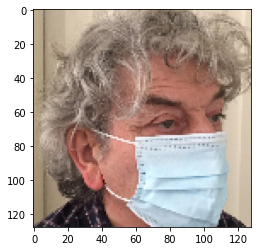

In [109]:
show_image(random.randint(0, len(im_names)-1), im_arrays, im_names, y_binary, y_subj, y_mask_stat, y_mask_type, y_angle)